# Portland Trail Blazers - Customer Lifetime Value (Clustering)
* StelllarAlgo Data Science
* Ryan Kazmerik
* Jul 15, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#from pandas_profiling import ProfileReport

## Data Wrangling

For our experiment, we need two datasets:
1. Fans who have bought tickets to a Trail Blazers game. We can get this from our Trail Blazers StellarAlgo tables.
2. Fans who have engaged with the Trail Blazers via streaming, or gaming data. This we can get from our dataset provided by the NBA.

### PTB Ticketing Dataset

In [2]:
"""
    data/ptb_cohort_purchase.csv contains data from the following query:

    SELECT p.dimcustomermasterid, p.purchasedate, p.ticketcount, p.revenue, p.isplanproduct, p.producttype, p.subproductname, p.seasonyear,
       c.dimcustomermasterid, c.county, c.stateprovince, c.zippostal 
    FROM "ptb_cohort_purchase"  p 
    INNER JOIN "ptb_dim_customer_master" c
    ON p.dimcustomermasterid = c.dimcustomermasterid
"""

df = pd.read_csv("./data/ptb_cohort_purchase.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975722 entries, 0 to 1975721
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   dimcustomermasterid    int64  
 1   purchasedate           object 
 2   ticketcount            int64  
 3   revenue                float64
 4   isplanproduct          bool   
 5   producttype            object 
 6   subproductname         object 
 7   seasonyear             int64  
 8   dimcustomermasterid.1  int64  
 9   county                 object 
 10  stateprovince          object 
 11  zippostal              object 
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 167.7+ MB


In [3]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,isplanproduct,producttype,subproductname,seasonyear,dimcustomermasterid.1,county,stateprovince,zippostal
0,608002,2018-05-08,2,124.00,True,Package,Quarter Season,2018,608002,Washington,OR,97223
1,608002,2019-05-21,2,136.00,True,Package,Quarter Season,2019,608002,Washington,OR,97223
2,608067,2019-03-18,4,252.00,False,Individual,Individual,2018,608067,Lane,OR,97477
3,563826,2018-02-28,2,111.72,True,Package,Full Season,2018,563826,Multnomah,OR,97219-7281
4,563826,2018-02-28,2,111.72,True,Package,Full Season,2018,563826,Multnomah,OR,97219-7281


### PTB Engagement Dataset

In [4]:
"""
  data/ptb_nba_engagement.parquet contains data from the following query:

  SELECT dimcustomermasterid, entity_source
  FROM "league-nba-poc"."tagged_customer_master";
"""

df2 = pd.read_csv("./data/ptb_nba_engagement.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671077 entries, 0 to 1671076
Data columns (total 2 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dimcustomermasterid  1671077 non-null  int64 
 1   entity_source        402626 non-null   object
dtypes: int64(1), object(1)
memory usage: 25.5+ MB


## Data Preprocessing

For our analysis we will only consider **non-package buyers**, let's see how much data we have for NP buyers and what sub-products are included:

In [5]:
df['isplanproduct'].value_counts()

True     1017544
False     958178
Name: isplanproduct, dtype: int64

Remove the rows where isplanproduct = True:

In [6]:
df = df[df['isplanproduct'] == False]

df.drop(columns=["isplanproduct"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958178 entries, 2 to 1975721
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   dimcustomermasterid    958178 non-null  int64  
 1   purchasedate           958178 non-null  object 
 2   ticketcount            958178 non-null  int64  
 3   revenue                411459 non-null  float64
 4   producttype            958178 non-null  object 
 5   subproductname         958178 non-null  object 
 6   seasonyear             958178 non-null  int64  
 7   dimcustomermasterid.1  958178 non-null  int64  
 8   county                 692788 non-null  object 
 9   stateprovince          608520 non-null  object 
 10  zippostal              707654 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 87.7+ MB


Let's include data from 2018 to present in our analysis:

In [7]:
df = df[df["seasonyear"] >= 2018]
df.shape

(799757, 11)

We'll also have a look at the included product and subproduct types:

In [8]:
df["producttype"].value_counts()

Individual    691929
Comp           58778
Other          49050
Name: producttype, dtype: int64

In [9]:
df["subproductname"].value_counts()

Individual           691301
Comp                  58012
Group                 31173
Suite                 13225
Deposit                1847
Group Broker           1459
Suite Broker           1345
Comp Broker             766
Individual Broker       628
Deposit Broker            1
Name: subproductname, dtype: int64

Let's remove the broker records so we are looking at actual customers:

In [10]:
df = df[df["subproductname"].isin(["Individual"])]
df.reset_index(drop=True, inplace=True)

df["subproductname"].value_counts()

Individual    691301
Name: subproductname, dtype: int64

In [11]:
df.head(10)

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear,dimcustomermasterid.1,county,stateprovince,zippostal
0,608067,2019-03-18,4,252.00,Individual,Individual,2018,608067,Lane,OR,97477
1,595882,2018-11-06,2,149.00,Individual,Individual,2018,595882,NaN,BC,V1M1Z8
2,595927,2019-10-25,3,37.50,Individual,Individual,2019,595927,Washington,OR,97124
3,575448,2020-02-06,2,133.56,Individual,Individual,2019,575448,Clackamas,OR,97034
4,608129,2021-05-25,2,100.00,Individual,Individual,2020,608129,Washington,OR,97123
5,624738,2021-10-26,2,10.00,Individual,Individual,2021,624738,Multnomah,OR,97212
6,624764,2021-05-25,1,62.00,Individual,Individual,2020,624764,Multnomah,OR,97211
7,565870,2018-10-12,3,48.75,Individual,Individual,2018,565870,Clark,WA,98685
8,575451,2019-02-14,4,120.00,Individual,Individual,2018,575451,NaN,NaN,NaN
9,575451,2021-10-26,2,10.00,Individual,Individual,2021,575451,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

Let's have a look at the data and decide whether we need any data cleaning and data transformation for further analysis.

In [12]:
#profile = ProfileReport(df, minimal=True)
#profile.to_file("pandas-profile-report.html")

By reading the profiling report, we can see that the following actions should be taken to improve the dataset quality:
* Remove missing values from revenue (33.3%)
* Remove zero values from revenue (7.4%)

In [13]:
df.dropna(subset=['revenue'], inplace=True)
df['revenue'].isnull().sum()

0

Let's also drop any rows where revenue = 0, and then check the value counts to ensure the zero values are gone

In [14]:
df = df[df['revenue'] > 0]
df['revenue'].value_counts(bins=[0, 1000, 10000, 100000])

(-0.001, 1000.0]       198888
(1000.0, 10000.0]        4225
(10000.0, 100000.0]        17
Name: revenue, dtype: int64

### Data Types

Let's look at the data types in our dataframe to see if we need to convert any values to a different type

In [15]:
df.dtypes

dimcustomermasterid        int64
purchasedate              object
ticketcount                int64
revenue                  float64
producttype               object
subproductname            object
seasonyear                 int64
dimcustomermasterid.1      int64
county                    object
stateprovince             object
zippostal                 object
dtype: object

Purchase date should be a datetime not an object (string), all of the other inferred data types look correct

In [16]:
df['purchasedate'] =  pd.to_datetime(df['purchasedate'], format='%Y-%m-%d')

## Customer Segmentation

**RFM** stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

* Mid Value: In the middle of everything. Often purchasing (but not as much as our High Values), fairly frequent and generates moderate revenue.

* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

### Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [17]:
# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_customer = pd.DataFrame(df['dimcustomermasterid'].unique())
df_customer.columns = ['dimcustomermasterid']

# get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('dimcustomermasterid')["purchasedate"].max().reset_index()
df_max_purchase.columns = ['dimcustomermasterid','maxpurchasedate']

# we take our observation point as the max invoice date in our dataset
df_max_purchase['recency'] = (df_max_purchase['maxpurchasedate'].max() - df_max_purchase['maxpurchasedate']).dt.days

#merge this dataframe to our new user dataframe
df_customer = pd.merge(df_customer, df_max_purchase[['dimcustomermasterid','recency']], on='dimcustomermasterid')

df_customer.head()

,dimcustomermasterid,recency
0,608067,1120
1,595882,1252
2,595927,899
3,575448,96
4,608129,321


In [18]:
df_customer["recency"].describe()

count    122337.000000
mean        661.077254
std         464.529627
min           0.000000
25%         149.000000
50%         820.000000
75%        1134.000000
max        1406.000000
Name: recency, dtype: float64

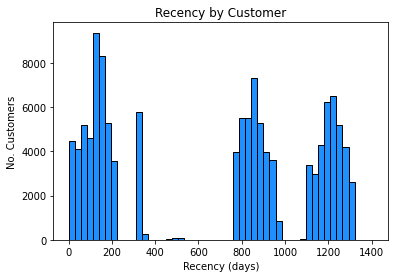

In [19]:
plt.hist(df_customer["recency"], bins=50, color="dodgerblue", edgecolor="black")
plt.title("Recency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Recency (days)")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

We can observe a large gap in purchasing behaviour between ~850 - 500 days ago, which aligns with when COVID-19 was declared a global pandemic. There's not much we can do to fill in that gap.

### Clustering Recency

We are going to apply K-means clustering to assign a recency score. We will use the elbow method to determine how many clusters we need:

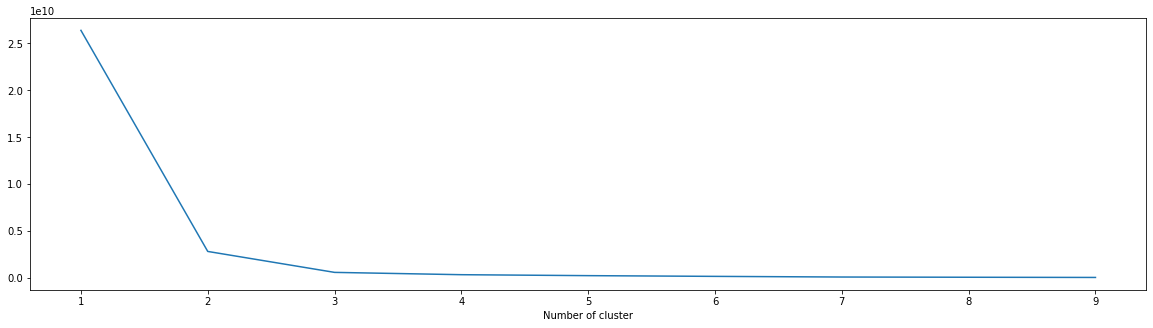

In [20]:
from sklearn.cluster import KMeans

cluster_dict={}
df_recency = df_customer[['recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    cluster_dict[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(cluster_dict.keys()), list(cluster_dict.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal number of clusters

In [21]:
# build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['recency']])
df_customer['recencycluster'] = kmeans.predict(df_customer[['recency']])

#function for ordering clusters from worst to best
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

df_customer = order_cluster('recencycluster', 'recency', df_customer, False)

In [22]:
df_customer.groupby('recencycluster')["recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recencycluster,,,,,,,,
0,35344.0,1210.681247,56.618952,1096.0,1170.0,1212.0,1254.0,1406.0
1,36065.0,855.958686,56.434789,502.0,812.0,855.0,895.0,978.0
2,50928.0,141.645853,86.805924,0.0,76.0,133.0,175.0,497.0


### Frequency

To create frequency clusters, we first need to find total number orders for each customer:

In [23]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('dimcustomermasterid')["purchasedate"].count().reset_index()
df_frequency.columns = ['dimcustomermasterid','frequency']

#add this data to our main dataframe
df_customer = pd.merge(df_customer, df_frequency, on="dimcustomermasterid")

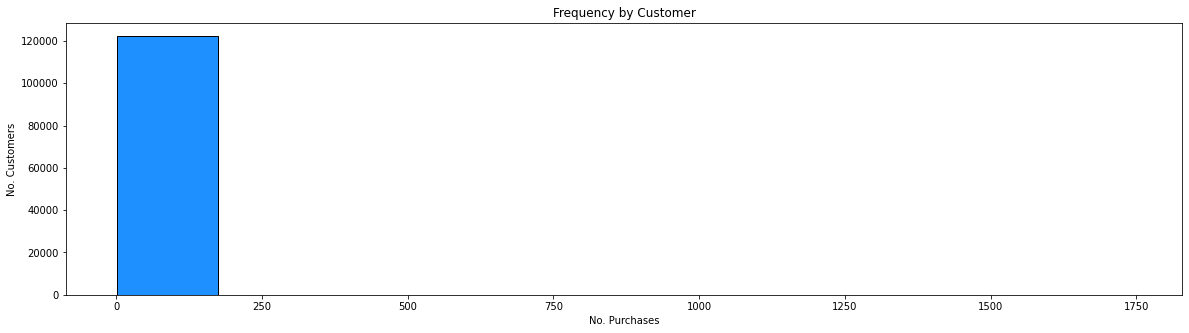

In [24]:
plt.hist(df_customer["frequency"], color="dodgerblue", edgecolor="black")
plt.title("Frequency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("No. Purchases")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

In [25]:
df_customer["frequency"].value_counts(bins=[0, 5, 10, 100, 1000])

(-0.001, 5.0]      118992
(5.0, 10.0]          2487
(10.0, 100.0]         843
(100.0, 1000.0]        14
Name: frequency, dtype: int64

Most customers have a lower frequency, but a few big purchasers are also present in the data. Because this analysis is focused on the typical individual ticket buyer, let's remove these outliers:

In [26]:
df_customer = df_customer[df_customer["frequency"] <= 10]

In [27]:
df_customer["frequency"].describe()

count    121479.000000
mean          1.482388
std           1.158215
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: frequency, dtype: float64

In [28]:
# build 3 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['frequency']])
df_customer['frequencycluster'] = kmeans.predict(df_customer[['frequency']])

df_customer = order_cluster('frequencycluster', 'frequency', df_customer, True)

In [29]:
df_customer.groupby('frequencycluster')["frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
frequencycluster,,,,,,,,
0,91502.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,23448.0,2.249062,0.432479,2.0,2.0,2.0,2.0,3.0
2,6529.0,5.489508,1.690766,4.0,4.0,5.0,6.0,10.0


### Revenue

Let’s add revenue to our dataset and cluster based on revenue:

In [30]:
df_revenue = df.groupby("dimcustomermasterid")["revenue"].sum().reset_index()

df_customer = pd.merge(df_customer, df_revenue, on="dimcustomermasterid")

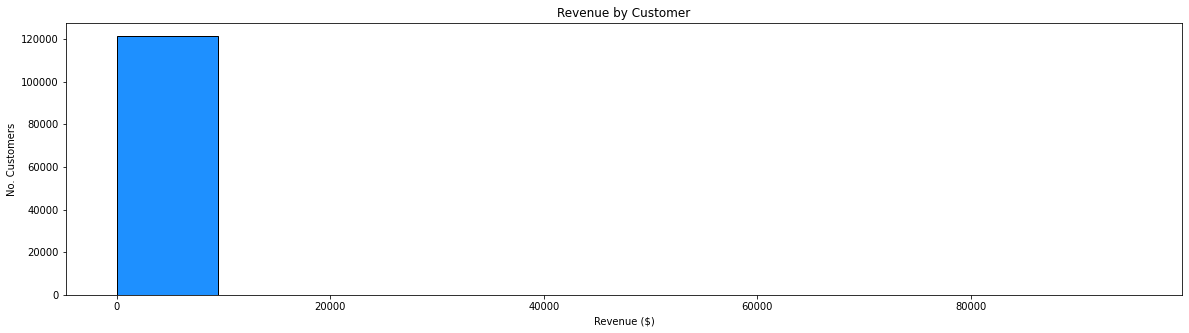

In [31]:
plt.hist(df_customer["revenue"], color="dodgerblue", edgecolor="black")
plt.title("Revenue by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Revenue ($)")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

In [32]:
df_customer["revenue"].value_counts(bins=[0, 50, 100, 500, 1000, 5000, 10000])

(100.0, 500.0]       64412
(50.0, 100.0]        20217
(-0.001, 50.0]       17315
(500.0, 1000.0]      13260
(1000.0, 5000.0]      6089
(5000.0, 10000.0]      147
Name: revenue, dtype: int64

Again, a few big spenders are present in the dataset. Let's remove the outlier customers who spend generate significantly more revenue than most:

In [33]:
df_customer = df_customer[df_customer["revenue"] <= 5000]

In [34]:
df_customer["revenue"].describe()

count    121293.000000
mean        303.314970
std         408.684054
min           1.000000
25%          80.280000
50%         176.000000
75%         357.020000
max        5000.000000
Name: revenue, dtype: float64

In [35]:
# build 3 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['revenue']])
df_customer['revenuecluster'] = kmeans.predict(df_customer[['revenue']])

df_customer = order_cluster('revenuecluster', 'revenue', df_customer, True)

In [36]:
df_customer.groupby("revenuecluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
revenuecluster,,,,,,,,
0,100606.0,167.458861,119.646774,1.00,68.000,136.00,245.32,477.20
1,18387.0,785.751368,273.277499,477.22,565.000,698.00,938.01,1588.89
2,2300.0,2389.133052,752.672597,1589.60,1807.945,2131.37,2748.96,5000.00


### Engagement

Let's add a flag to show whether the fan has engaged with the team via purchasing a streaming subscription, or video game engagement provided by via the NBA dataset:

In [37]:

# merge the NBA dataset with our customer dataset
df_customer = pd.merge(df_customer, df2, on="dimcustomermasterid")

# create a flag based on the source of the record
df_customer["is_engaged"] = np.where(df_customer["entity_source"] == "PTB", 1, 0)

df_customer["is_engaged"].value_counts()


0    118122
1      3171
Name: is_engaged, dtype: int64

### Overall Score

We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [38]:
# calculate overall score and use mean() to see details
df_customer["score"] = df_customer["recencycluster"]+df_customer["frequencycluster"]+df_customer["revenuecluster"]+df_customer["is_engaged"]
df_customer.groupby("score")["recency","frequency","revenue","is_engaged"].mean()

/var/folders/kp/vwm5bxcd72j3yf54l1xtsts80000gp/T/ipykernel_91887/2921998907.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customer.groupby("score")["recency","frequency","revenue","is_engaged"].mean()


,recency,frequency,revenue,is_engaged
score,,,,
0,1211.837921,1.000000,151.542762,0.000000
1,930.449403,1.110368,219.656423,0.016737
2,325.161502,1.191660,230.133196,0.015480
3,300.819798,2.054781,452.111166,0.060926
4,258.634853,3.245173,764.415741,0.085787
5,213.369205,4.994371,1140.917460,0.119868
6,184.826531,6.221088,2197.953617,0.219955
7,168.545455,6.600000,2563.874364,1.000000


As we can see, the higher the score, the higher value a fan (more recent purchase, higher frequency, higher revenue, more engagement)

### Visualization

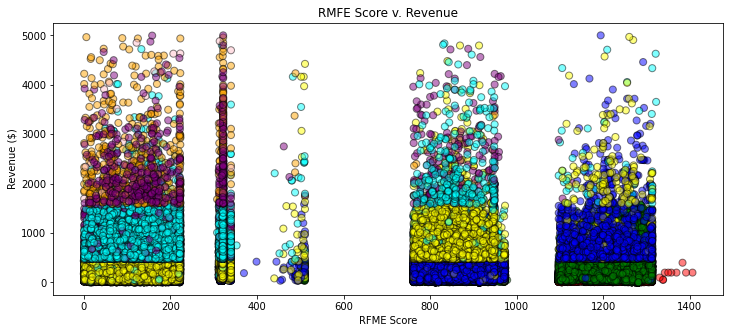

In [42]:
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'cyan', 5:'purple', 6:'orange', 7:'pink'}

fig = plt.scatter(df_customer["recency"], df_customer["revenue"], c=df_customer["score"].map(colors), edgecolors="black", s=50, alpha=.5)
plt.title("RMFE Score v. Revenue")
plt.ylabel("Revenue ($)")
plt.xlabel("RFME Score")
plt.rcParams["figure.figsize"] = (12,5)

plt.show()

## TODO:
* calculate silhouette score for clusters
* change clustering to Pycaret
* clustering on distToVenue to create segments
* add metric to RFM score (RFM+E)
    SELECT * FROM "league-nba-poc"."tagged_customer_master" WHERE entity_source = 'PTB';
    - match records on dimcustomermasterid
    - any record that matches this dataset means they have engagement (streaming, favourite team, favourite player)

* Ouput metric = GPR per RMF group
* For each segment, calculate overall GPR (for all fans), divide by num fans to get Avg GPR/fan of the segment.

Seg 1 -> Avg GPR/fan = $1000
Seg 2 -> Avg GPR/fan = $500
Seg 3 -> Avg GPR/fan = $50


* For creating NBA segments:
    - Segment 1 (In-market): country= USA, state=["OR","WA"] or zipcode starts with [97, 98] 
    - Segment 2 (US Out-of-market): country= USA, state!=["OR","WA"] or zipcode not starts with [97, 98] 
    - Segment 3 (International): country!= USA

* For creating PTB segments:
    - Follow same segment logic
    - joing to dw.cohortcustomer to get state, country, zip

FFV = FUTURE FAN VALUE
PFV = PRESENT FAN VALUE
